In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, roc_curve, auc
import timm
from peft import LoraConfig, get_peft_model
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
class FineTuningViT(nn.Module):
    def __init__(self, lora_config, num_classes=14, drop_rate=0.1):
        super(FineTuningViT, self).__init__()
        backbone = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=0, drop_rate=drop_rate)
        self.backbone = get_peft_model(backbone, lora_config)
        self.classifier = nn.Linear(self.backbone.embed_dim, num_classes)
    def forward(self, x):
        return self.classifier(self.backbone(x))

class CheXpertValDataset(Dataset):
    def __init__(self, data, root_dir, transforms):
        self.labels = torch.tensor(data.values.astype(np.float32))
        self.root_dir = root_dir
        self.img_paths = [os.path.join(self.root_dir, img_path) for img_path in data.index]
        self.transform = transforms
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            image = Image.open(img_path).convert('RGB')
            return self.transform(image=np.array(image))['image'], self.labels[idx]
        except (IOError, FileNotFoundError):
            return torch.zeros((3, 224, 224)), torch.zeros(14)

def get_predictions(model, loader, device):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Predictions"):
            outputs = torch.sigmoid(model(images.to(device)))
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

def calculate_f1_thresholds(y_true, y_pred, classes):
    """
    This function finds the single best threshold for each disease by
    maximizing the standard F1-score (beta=1.0).
    """
    optimal_thresholds = {}
    print("\nCalculating optimal thresholds by maximizing F1-score...")
    for i, class_name in enumerate(classes):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        
        if len(thresholds) == 0:
             optimal_thresholds[class_name] = 0.5
             continue

        f1_scores = (2 * precision * recall) / (precision + recall + 1e-8)
        
        if len(f1_scores) > 1:
            best_idx = np.argmax(f1_scores[:-1])
            optimal_threshold = thresholds[best_idx]
        else: 
            optimal_threshold = 0.5
        
        optimal_thresholds[class_name] = optimal_threshold
        print(f"  - {class_name}: Optimal Threshold = {optimal_threshold:.4f}")
    return optimal_thresholds

def plot_auroc_curves(y_true, y_pred, classes, model_name):
    """
    Calculates and plots the AUROC curve for each class directly in the notebook.
    Also calculates and returns the mean AUROC score.
    """
    print("\nGenerating AUROC curves...")
    plt.figure(figsize=(14, 12))
    auroc_scores = []

    for i, class_name in enumerate(classes):
        if len(np.unique(y_true[:, i])) < 2:#edge case where the number of distinct samples is only 1, which is unlikely to happen
            print(f"  - Skipping {class_name}: not enough distinct samples.")
            continue
        
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        auroc_scores.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.4f})')

    mean_auroc = np.mean(auroc_scores)

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.5000)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'AUROC for {model_name} (Mean AUC = {mean_auroc:.4f})', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()
    print(f"Displayed AUROC plot for {model_name}")
    return mean_auroc


In [ ]:
def main():
    """
    Main function to run the model evaluation pipeline. It now shows plots
    inline and prints the mean AUROC score.
    """
    all_model_names = [
        'ViT-LoRA-U0',
        'ViT-LoRA-U1',
        'ViT-LoRA-contrastive-U0',
        'ViT-LoRA-contrastive-U1'
    ]
    
    classes = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

    for model_name in all_model_names:
        print(f"\n{'='*20} Processing model: {model_name} {'='*20}")
        
        CHECKPOINT_DIR, DEVICE = '', torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        LORA_CONFIG = LoraConfig(r=64, lora_alpha=256, target_modules=["qkv", "proj"], lora_dropout=0.1, bias="none")
        
        model_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.pth")
        if not os.path.exists(model_path):
            print(f"Error: Model file not found for {model_name}. Skipping.")
            continue

        if 'contrastive' in model_name:
            model = FineTuningViT(lora_config=LORA_CONFIG, num_classes=14)
        else:
            model = get_peft_model(timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=14), LORA_CONFIG)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))

        u_version = model_name[-1]
        val_csv_path = f'u{u_version}_val.csv'
        if not os.path.exists(val_csv_path):
            print(f"Error: Validation CSV not found for {model_name}. Skipping.")
            continue

        val_df = pd.read_csv(val_csv_path, index_col=0)
        val_df.index = val_df.index.str.replace('CheXpert-v1.0-small', 'chexpert')
        transforms = A.Compose([A.Resize(224, 224), A.Normalize(mean=[0.506, 0.506, 0.506], std=[0.287, 0.287, 0.287]), ToTensorV2()])
        val_dataset = CheXpertValDataset(val_df, root_dir='', transforms=transforms)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

        y_pred, y_true = get_predictions(model, val_loader, DEVICE)
        
        # Plot AUROC curves and get the mean score.
        mean_auroc = plot_auroc_curves(y_true, y_pred, classes, model_name)
        print(f"\n  -> Mean AUROC Score on Validation Set: {mean_auroc:.4f}")

        new_thresholds = calculate_f1_thresholds(y_true, y_pred, classes)
        
        y_pred_final = np.zeros_like(y_pred)
        for i, class_name in enumerate(classes):
            y_pred_final[:, i] = (y_pred[:, i] >= new_thresholds.get(class_name, 0.5)).astype(int)
        
        report = classification_report(y_true, y_pred_final, target_names=classes, output_dict=True, zero_division=0)
        macro_f1 = report['macro avg']['f1-score']
        print(f"\n  -> Resulting Macro Avg F1-Score on Validation Set: {macro_f1:.4f}")
        output_filename = os.path.join(CHECKPOINT_DIR, f'{model_name}_best_tuned.csv')
        pd.DataFrame(list(new_thresholds.items()), columns=['class', 'threshold']).to_csv(output_filename, index=False)
        print(f"Successfully saved final F1-tuned thresholds to '{output_filename}'")

    print(f"\n{'='*20} All threshold files have been generated and AUROC plots displayed. {'='*20}")


==================== Processing model: ViT-LoRA-U0 ====================


Getting Predictions: 100%|██████████| 592/592 [03:22<00:00,  2.92it/s]



Generating AUROC curves...


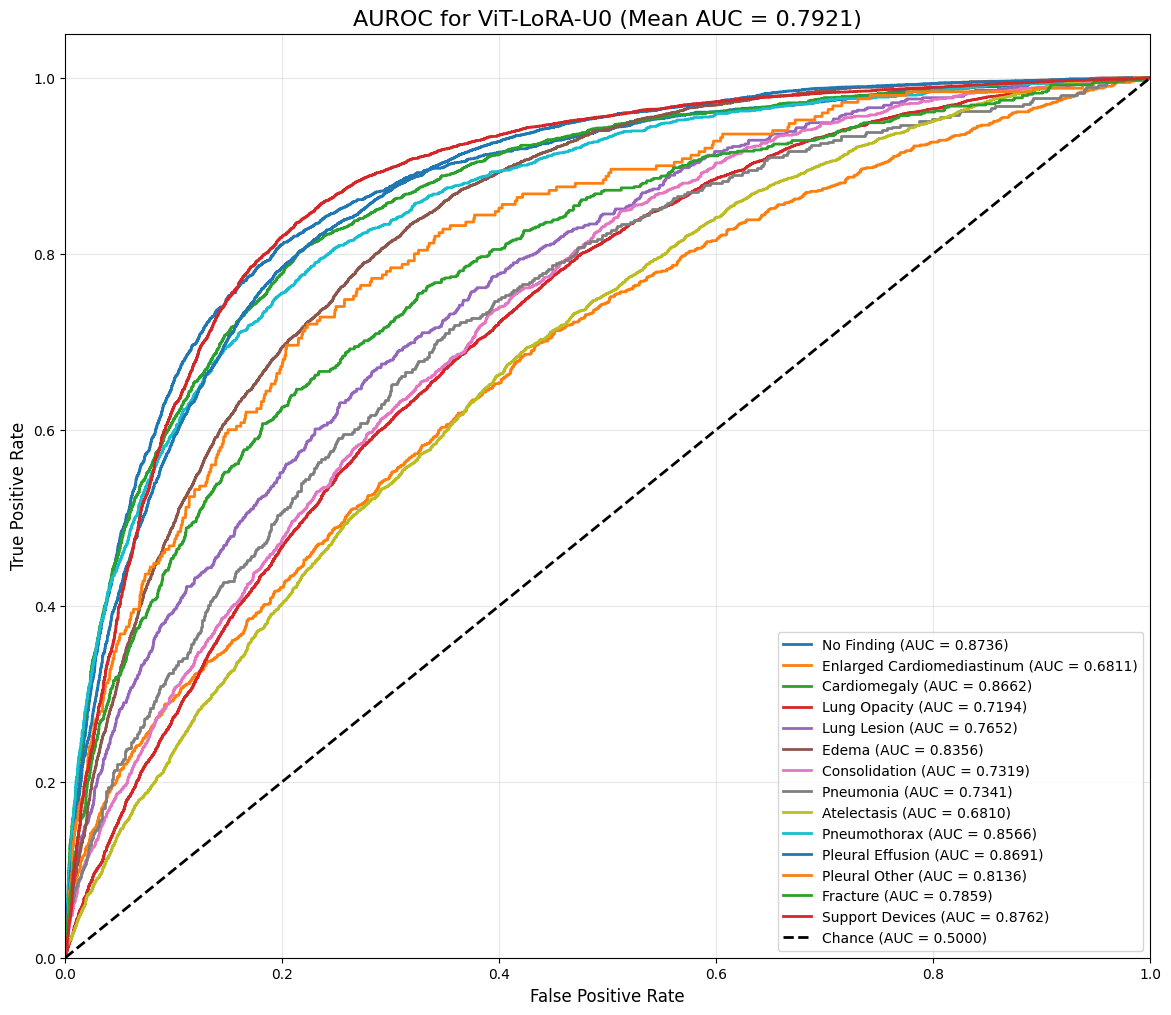

Displayed AUROC plot for ViT-LoRA-U0

  -> Mean AUROC Score on Validation Set: 0.7921

Calculating optimal thresholds by maximizing F1-score...
  - No Finding: Optimal Threshold = 0.1963
  - Enlarged Cardiomediastinum: Optimal Threshold = 0.2569
  - Cardiomegaly: Optimal Threshold = 0.3971
  - Lung Opacity: Optimal Threshold = 0.4149
  - Lung Lesion: Optimal Threshold = 0.2806
  - Edema: Optimal Threshold = 0.3151
  - Consolidation: Optimal Threshold = 0.2824
  - Pneumonia: Optimal Threshold = 0.4002
  - Atelectasis: Optimal Threshold = 0.1772
  - Pneumothorax: Optimal Threshold = 0.3241
  - Pleural Effusion: Optimal Threshold = 0.4311
  - Pleural Other: Optimal Threshold = 0.5066
  - Fracture: Optimal Threshold = 0.2787
  - Support Devices: Optimal Threshold = 0.4822

  -> Resulting Macro Avg F1-Score on Validation Set: 0.4336
Successfully saved final F1-tuned thresholds to 'ViT-LoRA-U0_best_tuned.csv'

==================== Processing model: ViT-LoRA-U1 ====================


Getting Predictions: 100%|██████████| 588/588 [03:22<00:00,  2.91it/s]



Generating AUROC curves...


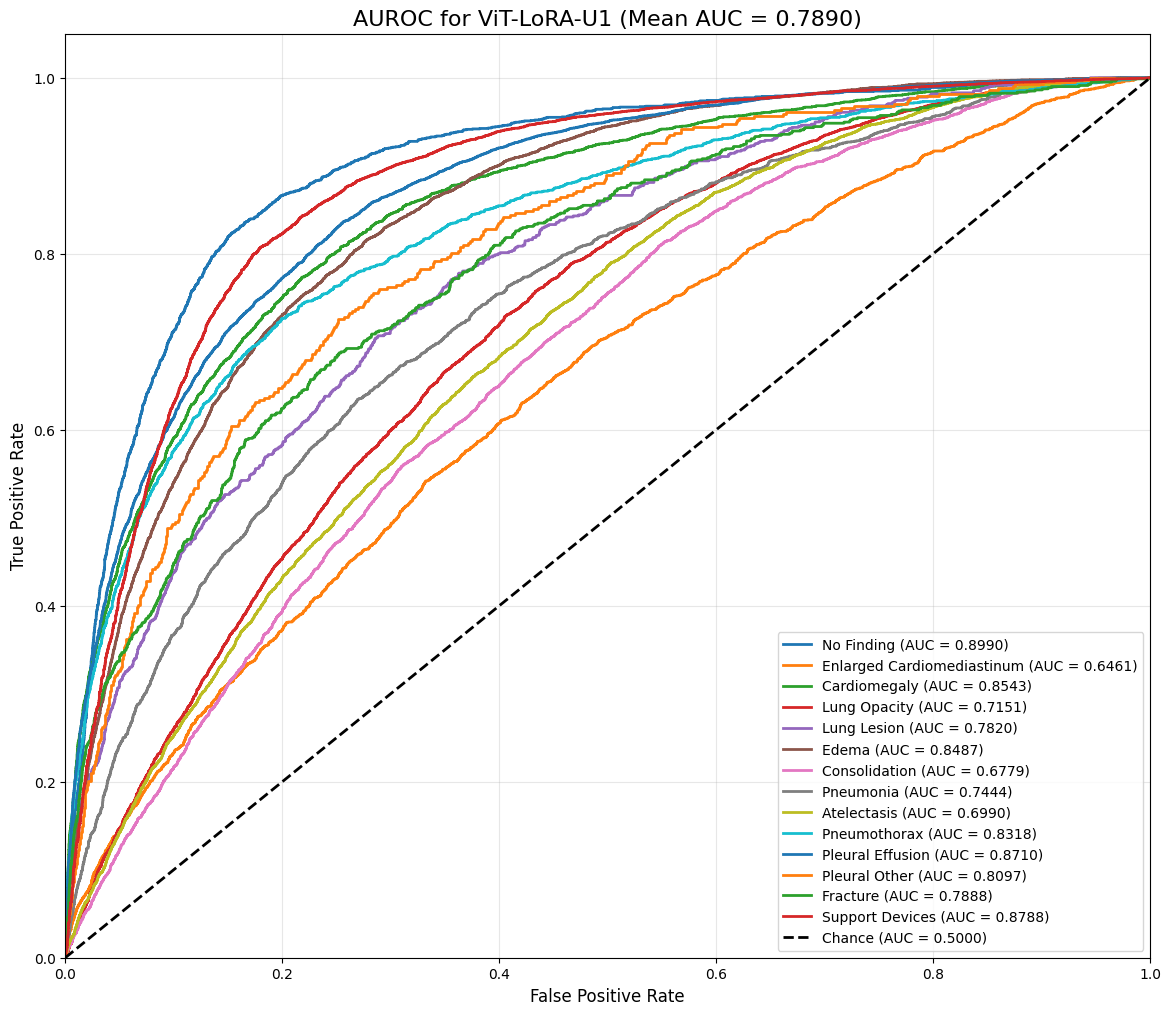

Displayed AUROC plot for ViT-LoRA-U1

  -> Mean AUROC Score on Validation Set: 0.7890

Calculating optimal thresholds by maximizing F1-score...
  - No Finding: Optimal Threshold = 0.2588
  - Enlarged Cardiomediastinum: Optimal Threshold = 0.1857
  - Cardiomegaly: Optimal Threshold = 0.3137
  - Lung Opacity: Optimal Threshold = 0.3464
  - Lung Lesion: Optimal Threshold = 0.3023
  - Edema: Optimal Threshold = 0.3851
  - Consolidation: Optimal Threshold = 0.1806
  - Pneumonia: Optimal Threshold = 0.2269
  - Atelectasis: Optimal Threshold = 0.2253
  - Pneumothorax: Optimal Threshold = 0.2928
  - Pleural Effusion: Optimal Threshold = 0.4122
  - Pleural Other: Optimal Threshold = 0.3983
  - Fracture: Optimal Threshold = 0.3734
  - Support Devices: Optimal Threshold = 0.4918

  -> Resulting Macro Avg F1-Score on Validation Set: 0.4976
Successfully saved final F1-tuned thresholds to 'ViT-LoRA-U1_best_tuned.csv'

==================== Processing model: ViT-LoRA-contrastive-U0 ===================

Getting Predictions: 100%|██████████| 592/592 [03:23<00:00,  2.90it/s]



Generating AUROC curves...


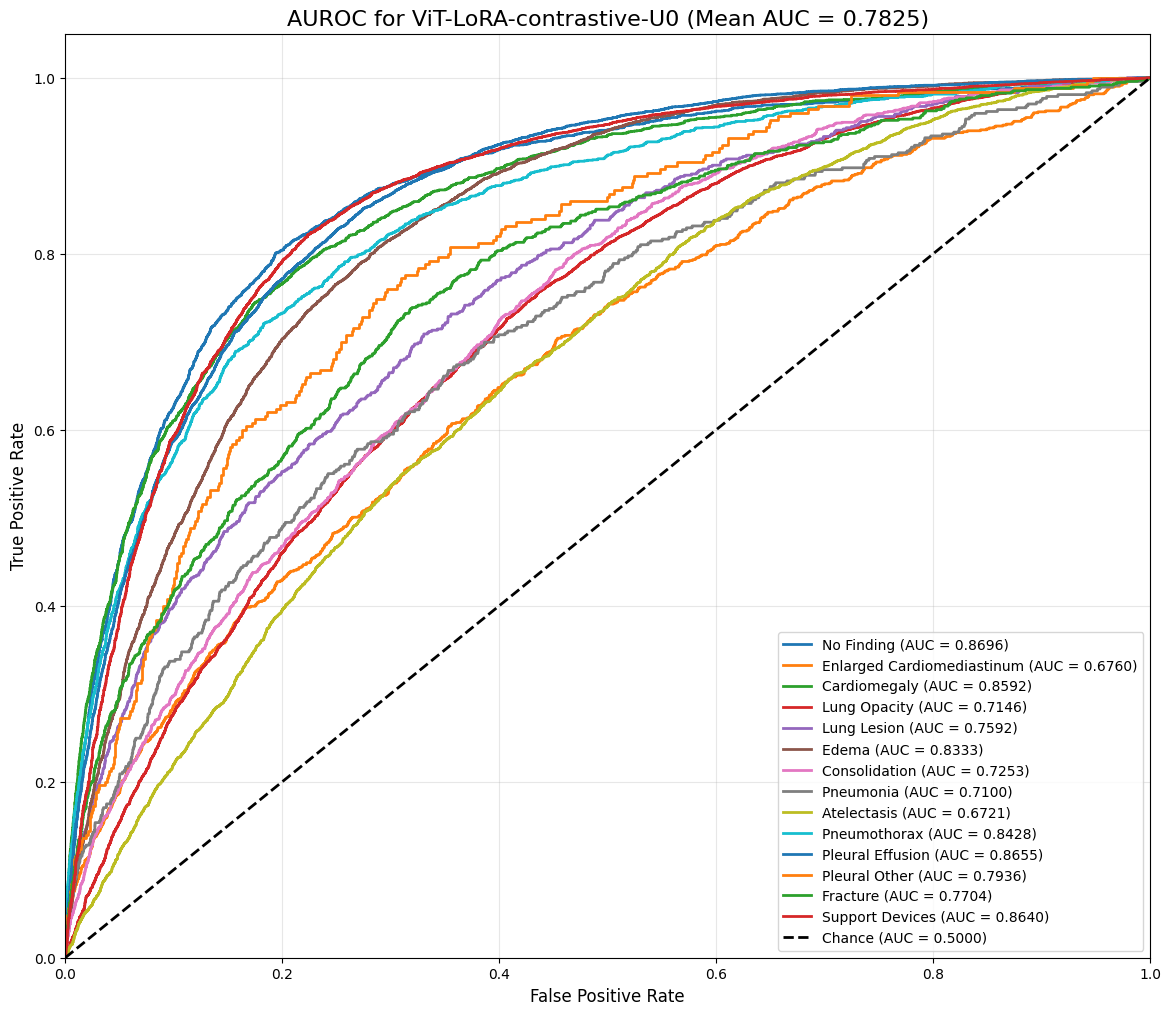

Displayed AUROC plot for ViT-LoRA-contrastive-U0

  -> Mean AUROC Score on Validation Set: 0.7825

Calculating optimal thresholds by maximizing F1-score...
  - No Finding: Optimal Threshold = 0.1355
  - Enlarged Cardiomediastinum: Optimal Threshold = 0.2676
  - Cardiomegaly: Optimal Threshold = 0.5444
  - Lung Opacity: Optimal Threshold = 0.3149
  - Lung Lesion: Optimal Threshold = 0.2211
  - Edema: Optimal Threshold = 0.3177
  - Consolidation: Optimal Threshold = 0.1747
  - Pneumonia: Optimal Threshold = 0.3962
  - Atelectasis: Optimal Threshold = 0.2348
  - Pneumothorax: Optimal Threshold = 0.2884
  - Pleural Effusion: Optimal Threshold = 0.3298
  - Pleural Other: Optimal Threshold = 0.6619
  - Fracture: Optimal Threshold = 0.3324
  - Support Devices: Optimal Threshold = 0.3880

  -> Resulting Macro Avg F1-Score on Validation Set: 0.4252
Successfully saved final F1-tuned thresholds to 'ViT-LoRA-contrastive-U0_best_tuned.csv'

==================== Processing model: ViT-LoRA-contrastiv

Getting Predictions: 100%|██████████| 588/588 [03:22<00:00,  2.90it/s]



Generating AUROC curves...


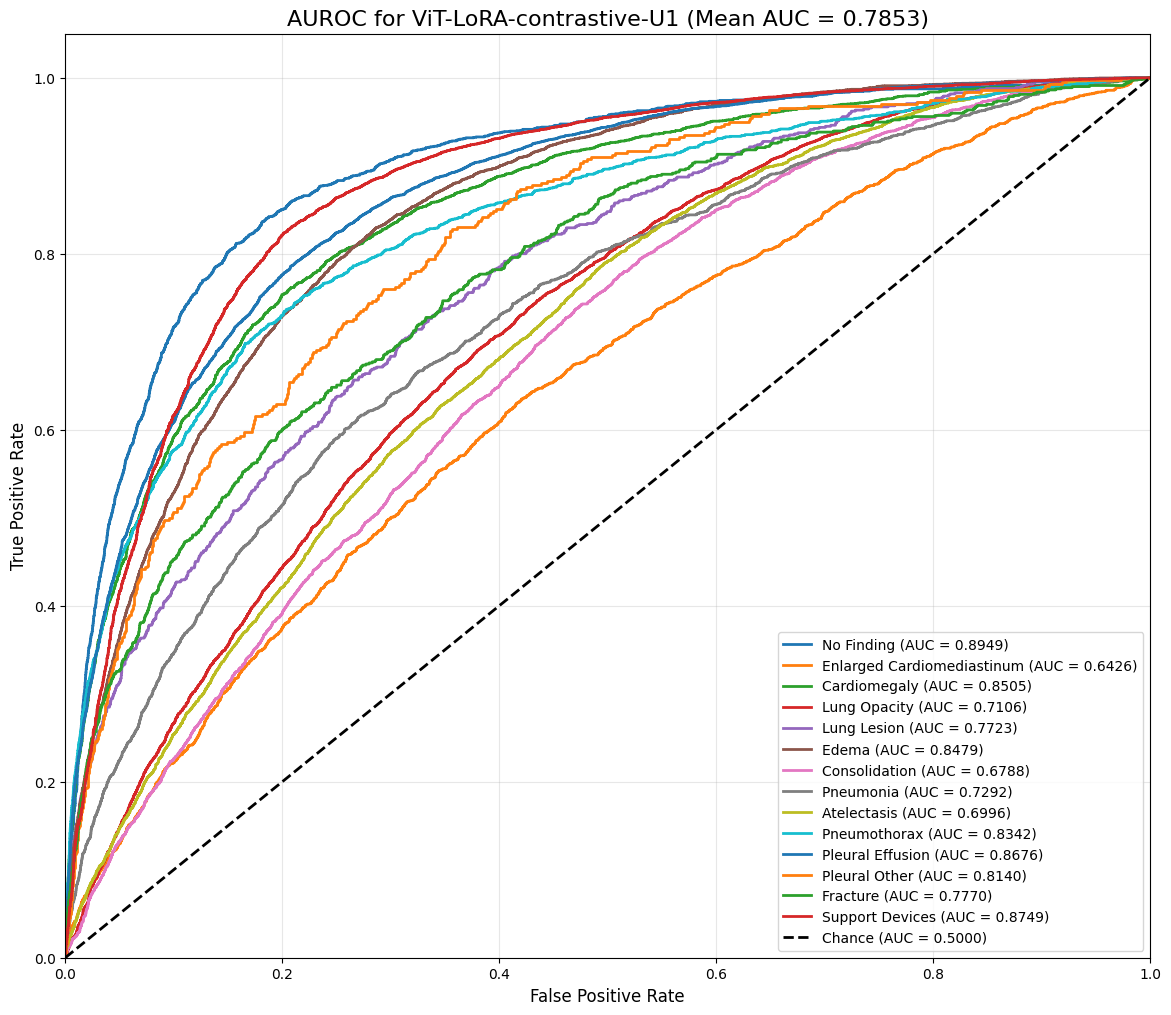

Displayed AUROC plot for ViT-LoRA-contrastive-U1

  -> Mean AUROC Score on Validation Set: 0.7853

Calculating optimal thresholds by maximizing F1-score...
  - No Finding: Optimal Threshold = 0.1693
  - Enlarged Cardiomediastinum: Optimal Threshold = 0.1670
  - Cardiomegaly: Optimal Threshold = 0.4044
  - Lung Opacity: Optimal Threshold = 0.3317
  - Lung Lesion: Optimal Threshold = 0.3734
  - Edema: Optimal Threshold = 0.3857
  - Consolidation: Optimal Threshold = 0.2186
  - Pneumonia: Optimal Threshold = 0.2592
  - Atelectasis: Optimal Threshold = 0.3173
  - Pneumothorax: Optimal Threshold = 0.2633
  - Pleural Effusion: Optimal Threshold = 0.4655
  - Pleural Other: Optimal Threshold = 0.4929
  - Fracture: Optimal Threshold = 0.3646
  - Support Devices: Optimal Threshold = 0.4374

  -> Resulting Macro Avg F1-Score on Validation Set: 0.4970
Successfully saved final F1-tuned thresholds to 'ViT-LoRA-contrastive-U1_best_tuned.csv'

==================== All threshold files have been generat

In [4]:
main()